### Import packages

In [18]:
from ml_metadata.metadata_store import metadata_store
from ml_metadata.proto import metadata_store_pb2

import tensorflow as tf
import tensorflow_data_validation as tfdv

import urllib
import zipfile

### Download dataset 

In [19]:
url  = 'https://storage.googleapis.com/artifacts.tfx-oss-public.appspot.com/datasets/chicago_data.zip'
zip, headers = urllib.request.urlretrieve(url)
zipfile.ZipFile(zip).extractall()
zipfile.ZipFile(zip).close()

print("Files downloaded: ")
!ls -R data

Files downloaded: 
data:
IDs_mapping.csv
IDs_mapping.csv:Zone.Identifier
adult.data
adult.data:Zone.Identifier
breast_cancer_data.csv
breast_cancer_data.csv:Zone.Identifier
census_data
diabetic_data.csv
diabetic_data.csv:Zone.Identifier
eval
metro_traffic
metro_traffic_volume.csv
metro_traffic_volume.csv:Zone.Identifier
serving
train

data/census_data:
adult.data

data/eval:
data.csv

data/metro_traffic:
metro_traffic_volume.csv

data/serving:
data.csv

data/train:
data.csv


## Process Outline

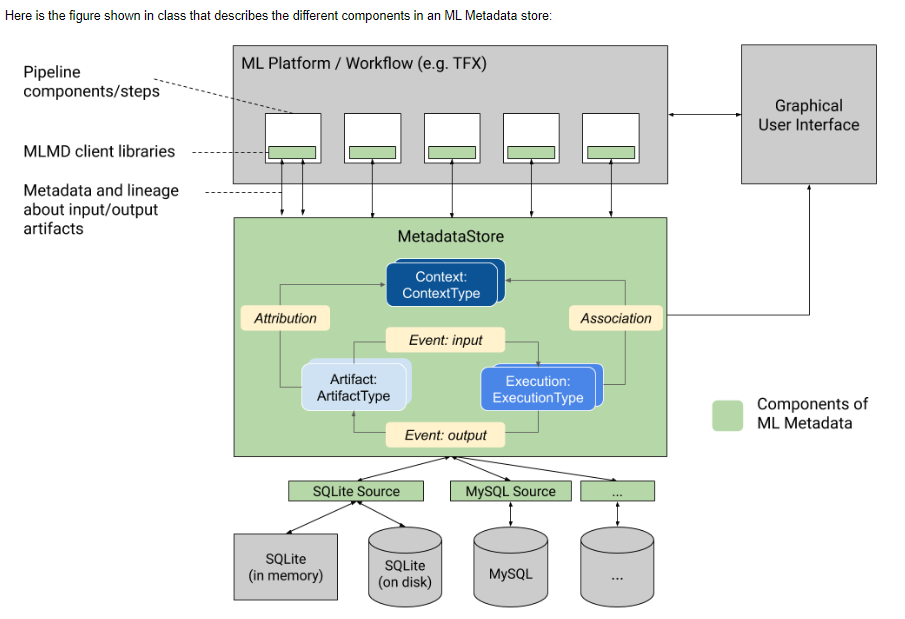

The green box in the middle shows the data model followed by ML Metadata. The [official documentation](https://www.tensorflow.org/tfx/guide/mlmd#data_model) describe each of these and we'll show it here as well for easy reference:

* `ArtifactType` describes an artifact's type and its properties that are stored in the metadata store. You can register these types on-the-fly with the metadata store in code, or you can load them in the store from a serialized format. Once you register a type, its definition is available throughout the lifetime of the store.
* An `Artifact` describes a specific instance of an ArtifactType, and its properties that are written to the metadata store.
* An `ExecutionType` describes a type of component or step in a workflow, and its runtime parameters.
* An `Execution` is a record of a component run or a step in an ML workflow and the runtime parameters. An execution can be thought of as an instance of an ExecutionType. Executions are recorded when you run an ML pipeline or step.
* An `Event` is a record of the relationship between artifacts and executions. When an execution happens, events record every artifact that was used by the execution, and every artifact that was produced. These records allow for lineage tracking throughout a workflow. By looking at all events, MLMD knows what executions happened and what artifacts were created as a result. MLMD can then recurse back from any artifact to all of its upstream inputs.
* A `ContextType` describes a type of conceptual group of artifacts and executions in a workflow, and its structural properties. For example: projects, pipeline runs, experiments, owners etc.
* A `Context` is an instance of a ContextType. It captures the shared information within the group. For example: project name, changelist commit id, experiment annotations etc. It has a user-defined unique name within its ContextType.
* An `Attribution` is a record of the relationship between artifacts and contexts.
* An `Association` is a record of the relationship between executions and contexts.

As mentioned earlier, you will use TFDV to generate a schema and record this process in the ML Metadata store. You will be starting from scratch so you will be defining each component of the data model. The outline of steps involve:

1. Defining the ML Metadata's storage database
1. Setting up the necessary artifact types
1. Setting up the execution types
1. Generating an input artifact unit
1. Generating an execution unit
1. Registering an input event
1. Running the TFDV component
1. Generating an output artifact unit
1. Registering an output event
1. Updating the execution unit
1. Seting up and generating a context unit
1. Generating attributions and associations

You can then retrieve information from the database to investigate aspects of your project. For example, you can find which dataset was used to generate a particular schema. You will also do that in this exercise.

For each of these steps, you may want to have the [MetadataStore API documentation](https://www.tensorflow.org/tfx/ml_metadata/api_docs/python/mlmd/MetadataStore) open so you can lookup any of the methods you will be using to interact with the metadata store. You can also look at the `metadata_store` protocol buffer [here](https://github.com/google/ml-metadata/blob/r0.24.0/ml_metadata/proto/metadata_store.proto) to see descriptions of each data type covered in this tutorial.

### Defining ML Metadata's Storage Database

In [20]:
connection_config = metadata_store_pb2.ConnectionConfig()
connection_config.fake_database.SetInParent()
store = metadata_store.MetadataStore(connection_config)

### Register ArtifactType

In [21]:
#ArtifactType for input dataset
data_artifact_type = metadata_store_pb2.ArtifactType()
data_artifact_type.name = 'DataSet'
data_artifact_type.properties['name'] = metadata_store_pb2.STRING
data_artifact_type.properties['split'] = metadata_store_pb2.STRING
data_artifact_type.properties['version'] = metadata_store_pb2.INT

#Register ArtifactType to metadata store
data_artifact_type_id = store.put_artifact_type(data_artifact_type)

#ArtifactType for schema
schema_artifact_type = metadata_store_pb2.ArtifactType()
schema_artifact_type.name = 'Schema'
schema_artifact_type.properties['name'] = metadata_store_pb2.STRING
schema_artifact_type.properties['version'] = metadata_store_pb2.INT

#Register ArtifactType to metadata store
schema_artifact_type_id = store.put_artifact_type(schema_artifact_type)

print('Data artifact ID : ', data_artifact_type_id)
print('Data artifact type : \n',data_artifact_type)
print('Schema artifact ID : ', schema_artifact_type_id)
print('Schema artifact type : \n',schema_artifact_type)

Data artifact ID :  10
Data artifact type : 
 name: "DataSet"
properties {
  key: "name"
  value: STRING
}
properties {
  key: "split"
  value: STRING
}
properties {
  key: "version"
  value: INT
}

Schema artifact ID :  11
Schema artifact type : 
 name: "Schema"
properties {
  key: "name"
  value: STRING
}
properties {
  key: "version"
  value: INT
}



### Register ExecutionType

In [22]:
#ExecutionType for data validation component
dv_execution_type = metadata_store_pb2.ExecutionType()
dv_execution_type.name = 'Data Validation'
dv_execution_type.properties['state'] = metadata_store_pb2.STRING

#Register ExecutionType to metadata store
dv_execution_type_id = store.put_execution_type(dv_execution_type)

print('Data validation execution type ID : ',dv_execution_type_id)
print('Data validation execution type : \n', dv_execution_type)

Data validation execution type ID :  12
Data validation execution type : 
 name: "Data Validation"
properties {
  key: "state"
  value: STRING
}



### Generate input artifact unit

In [23]:
#Declare input artifact
data_artifact = metadata_store_pb2.Artifact()
data_artifact.uri = './data/train/data.csv'
data_artifact.type_id = data_artifact_type_id
data_artifact.properties['name'].string_value = 'Chicago Taxi dataset'
data_artifact.properties['split'].string_value = 'train'
data_artifact.properties['version'].int_value = 1

#Submit artifact unit to metadata store
data_artifact_id = store.put_artifacts([data_artifact])[0]

print('Data artifact ID : ', data_artifact_id)
print('Data artifact : \n', data_artifact)

Data artifact ID :  1
Data artifact : 
 type_id: 10
uri: "./data/train/data.csv"
properties {
  key: "name"
  value {
    string_value: "Chicago Taxi dataset"
  }
}
properties {
  key: "split"
  value {
    string_value: "train"
  }
}
properties {
  key: "version"
  value {
    int_value: 1
  }
}



### Generate execution unit

In [24]:
#Register the execution of data validation run
dv_execution = metadata_store_pb2.Execution()
dv_execution.type_id = dv_execution_type_id
dv_execution.properties['state'].string_value = 'RUNNING'

#Submit execution unit to metadata store
dv_execution_id = store.put_executions([dv_execution])[0]

print('Data validation execution ID : ', dv_execution_id)
print('Data valdation execution : \n', dv_execution)

Data validation execution ID :  1
Data valdation execution : 
 type_id: 12
properties {
  key: "state"
  value {
    string_value: "RUNNING"
  }
}



### Register input event

In [25]:
#Declare input event
input_event = metadata_store_pb2.Event()
input_event.artifact_id = data_artifact_id
input_event.execution_id = dv_execution_id
input_event.type = metadata_store_pb2.Event.DECLARED_INPUT

#Submit input event to the metadata store
store.put_events([input_event])

print('Input event : \n', input_event)

Input event : 
 artifact_id: 1
execution_id: 1
type: DECLARED_INPUT



### Run TFDV component

In [26]:
train_data = './data/train/data.csv'
train_stats = tfdv.generate_statistics_from_csv(data_location=train_data)
schema = tfdv.infer_schema(statistics=train_stats)

schema_file = './schema/schema.pbtxt'
tfdv.write_schema_text(schema, schema_file)

print('Dataset schema has been generated at : ', schema_file)

Dataset schema has been generated at :  ./schema/schema.pbtxt


### Generate output artifact unit

In [27]:
#Declare output artifact of type schema_artifact
schema_artifact = metadata_store_pb2.Artifact()
schema_artifact.uri = schema_file
schema_artifact.type_id = schema_artifact_type_id
schema_artifact.properties['version'].int_value = 1
schema_artifact.properties['name'].string_value = 'Chicago Taxi Schema'

#Submit output artifact to metadata store
schema_artifact_id = store.put_artifacts([schema_artifact])[0]

print('Schema artifact ID : ', schema_artifact_id)
print('Schema artifact : \n', schema_artifact)

Schema artifact ID :  2
Schema artifact : 
 type_id: 11
uri: "./schema/schema.pbtxt"
properties {
  key: "name"
  value {
    string_value: "Chicago Taxi Schema"
  }
}
properties {
  key: "version"
  value {
    int_value: 1
  }
}



### Register output event

In [28]:
output_event = metadata_store_pb2.Event()
output_event.artifact_id = schema_artifact_id
output_event.execution_id = dv_execution_id
output_event.type = metadata_store_pb2.Event.DECLARED_OUTPUT

store.put_events([output_event])
print('Output event : \n', output_event)

Output event : 
 artifact_id: 2
execution_id: 1
type: DECLARED_OUTPUT



### Update the execution unit

In [29]:
dv_execution.id = dv_execution_id
dv_execution.properties['state'].string_value = 'COMPLETED'

store.put_executions([dv_execution])
print('Data validation execution : \n', dv_execution)

Data validation execution : 
 id: 1
type_id: 12
properties {
  key: "state"
  value {
    string_value: "COMPLETED"
  }
}



### Setting up ContextType

In [30]:
expt_context_type = metadata_store_pb2.ContextType()
expt_context_type.name = 'Experiment'
expt_context_type.properties['note'] = metadata_store_pb2.STRING

expt_context_type_id = store.put_context_type(expt_context_type)
print('Experiment context ID : ', expt_context_type_id)
print('Experiment context : ',expt_context_type)

Experiment context ID :  13
Experiment context :  name: "Experiment"
properties {
  key: "note"
  value: STRING
}



### Generating Context unit

In [31]:
expt_context = metadata_store_pb2.Context()
expt_context.type_id = expt_context_type_id
expt_context.name = 'Demo'
expt_context.properties['note'].string_value = 'Walkthrough of metadata'

expt_context_id = store.put_contexts([expt_context])[0]

print('Experiment context ID : ', expt_context_id)
print('Experiment context : ',expt_context)

Experiment context ID :  1
Experiment context :  type_id: 13
name: "Demo"
properties {
  key: "note"
  value {
    string_value: "Walkthrough of metadata"
  }
}



### Generate attribution and association relationships 

In [32]:
expt_attribution = metadata_store_pb2.Attribution()
expt_attribution.artifact_id = schema_artifact_id
expt_attribution.context_id = expt_context_id

expt_association = metadata_store_pb2.Association()
expt_association.execution_id = dv_execution_id
expt_association.context_id = expt_context_id

store.put_attributions_and_associations([expt_attribution], [expt_association])

print('Attribution : \n', expt_attribution)
print('Association : \n', expt_association)

Attribution : 
 artifact_id: 2
context_id: 1

Association : 
 execution_id: 1
context_id: 1



### Retrieving information from metadata store

In [34]:
store.get_artifact_types()

[id: 10
 name: "DataSet"
 properties {
   key: "name"
   value: STRING
 }
 properties {
   key: "split"
   value: STRING
 }
 properties {
   key: "version"
   value: INT
 },
 id: 11
 name: "Schema"
 properties {
   key: "name"
   value: STRING
 }
 properties {
   key: "version"
   value: INT
 }]

In [42]:
schema_to_inv = store.get_artifacts_by_type('Schema')[0]
print(schema_to_inv)

id: 2
type_id: 11
uri: "./schema/schema.pbtxt"
properties {
  key: "name"
  value {
    string_value: "Chicago Taxi Schema"
  }
}
properties {
  key: "version"
  value {
    int_value: 1
  }
}
type: "Schema"
create_time_since_epoch: 1691479158447
last_update_time_since_epoch: 1691479158447



In [44]:
schema_events = store.get_events_by_artifact_ids([schema_to_inv.id])
print(schema_events)

[artifact_id: 2
execution_id: 1
type: DECLARED_OUTPUT
milliseconds_since_epoch: 1691479158459
]


In [45]:
execution_events = store.get_events_by_execution_ids([schema_events[0].execution_id])
print(execution_events)

[artifact_id: 1
execution_id: 1
type: DECLARED_INPUT
milliseconds_since_epoch: 1691479154794
, artifact_id: 2
execution_id: 1
type: DECLARED_OUTPUT
milliseconds_since_epoch: 1691479158459
]


In [49]:
artifact_input = execution_events[0]

store.get_artifacts_by_id([artifact_input.artifact_id])

[id: 1
 type_id: 10
 uri: "./data/train/data.csv"
 properties {
   key: "name"
   value {
     string_value: "Chicago Taxi dataset"
   }
 }
 properties {
   key: "split"
   value {
     string_value: "train"
   }
 }
 properties {
   key: "version"
   value {
     int_value: 1
   }
 }
 type: "DataSet"
 create_time_since_epoch: 1691479154034
 last_update_time_since_epoch: 1691479154034]